In [1]:

from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo
run_log_dir = "/mnt/network_drive/lrq/logs/logs_2025-10-29-16-59-52/run_0"
# run_log_dir = "/mnt/network_drive/lrq/logs/logs_2025-07-17-22-02-15/run_0"
GRAN = "2s"
memory_metric = "vllm:gpu_cache_usage_perc"
compute_metric = f"rate(vllm:iteration_tokens_total_sum[{GRAN}]) / rate(vllm:iteration_tokens_total_count[{GRAN}])"
queue_metric = f"rate(vllm:request_queue_time_seconds_sum[{GRAN}])"
throughput_metric = f"rate(vllm:iteration_tokens_total_sum[{GRAN}])"
# throughput_metric = f"vllm:avg_generation_throughput_toks_per_s"
tok_counter_metric = f"router:tok_counter"
metrics_list = [tok_counter_metric, queue_metric]
report_file_path = analyze_data(run_log_dir, metrics_list)
with open(report_file_path, 'r') as f:
    report = json.load(f)

loadgen_data = report['loadgen_data']
total_request_count = len(loadgen_data)
no_response_count = 0
error_count = 0
requests = []
for request_data in loadgen_data:
    if 'error' not in request_data.keys():
        request = RequestData.init_from_dict(request_data)
        requests.append(request)
        continue

    if request_data == {'error': 'No response!'}:
        no_response_count += 1
    else:
        error_count += 1
        print(request_data)

print(f"Total request: {total_request_count}, no response: {no_response_count}, error: {error_count}")
recv_kv_failed_requests = report['recv_failed_requests']
print(f"There are totally {len(recv_kv_failed_requests)} requests fall back to model forwarding!")

start_str = report.get('router_start_time', 'N/A')
end_str = report.get('router_end_time', 'N/A')
tz_sg = ZoneInfo("Asia/Singapore")
router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()
print(f"Router start time: {router_start_time}, end time: {router_end_time}")

Copying Prometheus snapshot from /data/metrics to /app/prometheus_restore...
Starting Prometheus from restored snapshot...


ts=2025-10-31T07:48:40.075Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-10-31T07:48:40.075Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-10-31T07:48:40.075Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-10-31T07:48:40.075Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 e000bc28326c (none))"
ts=2025-10-31T07:48:40.075Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-10-31T07:48:40.075Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-10-31T07:48:40.079Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:tok_counter', 'rate(vllm:request_queue_time_seconds_sum[2s])']
params_list: [{'query': 'router:tok_counter', 'start': '2025-10-29T09:03:40Z', 'end': '2025-10-29T11:03:40Z', 'step': '1s'}, {'query': 'rate(vllm:request_queue_time_seconds_sum[2s])', 'start': '2025-10-29T09:03:40Z', 'end': '2025-10-29T11:03:40Z', 'step': '1s'}]
Total request: 15639, no response: 207, error: 0
There are totally 0 requests fall back to model forwarding!
Router start time: 1761728409.974582, end time: 1761729216.843284


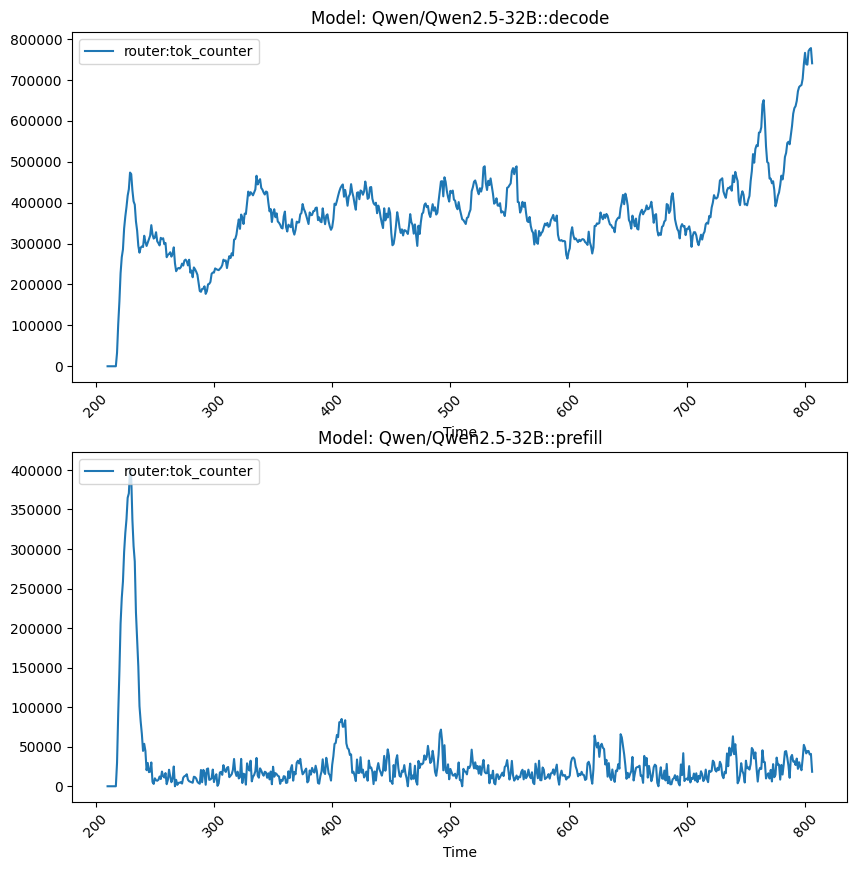

In [2]:

import matplotlib.pyplot as plt
from datetime import datetime
router_metrics = report['prom_data'].get("router", {})
num_models = len(router_metrics)
fig, axes = plt.subplots(num_models, 1, figsize=(10, 5 * num_models))
for i, (model_name, metrics) in enumerate(router_metrics.items()):
    ax = axes[i] if num_models > 1 else axes
    tok_counter_values = metrics.get(tok_counter_metric, [])
    tok_counter_values = [
        t for t in tok_counter_values 
        if float(t[0]) <= router_end_time
    ]
    timestamps = [float(t[0]) for t in tok_counter_values]
    timestamp_offsets = [t - router_start_time for t in timestamps]
    ax.plot(
        timestamp_offsets,
        [float(t[1]) for t in tok_counter_values],
        label=tok_counter_metric
    )
    ax.set_title(f"Model: {model_name}")
    ax.set_xlabel("Time")
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left')

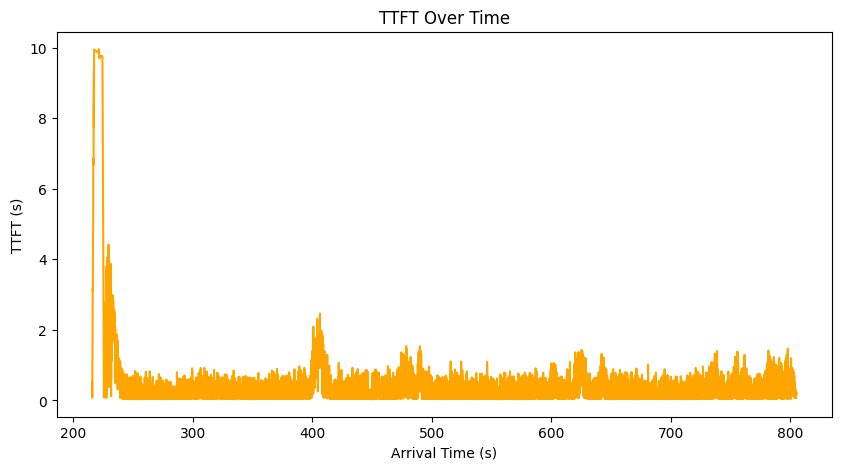

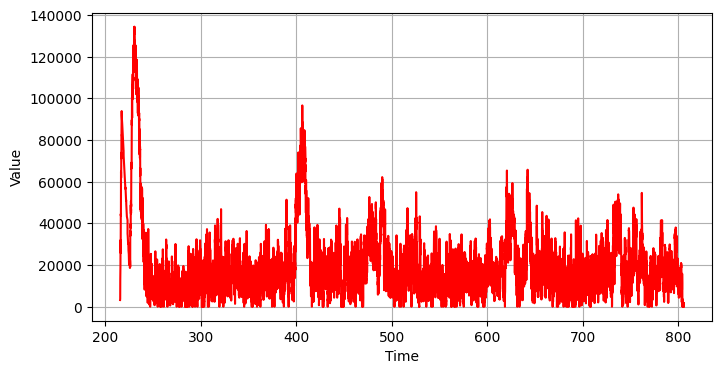

In [3]:
from time_series import EventTimestamp, TimeSeriesFunction
ttfts = []
prompt_tokens = []
arrival_timestamps = []
for request in requests:
    arrival_timestamps.append(request.arrival_time - router_start_time)
    prompt_tokens.append(request.prompt_tokens)
    ttfts.append(request.ttft)

combined = list(zip(arrival_timestamps, ttfts, prompt_tokens))
combined.sort(key=lambda x: x[0])

# Unzip the sorted tuples back into individual lists
arrival_timestamps, ttfts, prompt_tokens = map(list, zip(*combined))

# Sort by arrival_timestamps (first element of each tuple)
combined.sort(key=lambda x: x[0])
plt.figure(figsize=(10, 5))
plt.plot(arrival_timestamps, ttfts, label='TTFT', color='orange')
plt.xlabel('Arrival Time (s)')
plt.ylabel('TTFT (s)')
plt.title('TTFT Over Time')

events = []
for i, ts in enumerate(arrival_timestamps):
    arrive_event = EventTimestamp(ts, prompt_tokens[i])
    finished_event = EventTimestamp(ts+ttfts[i], -prompt_tokens[i])
    events.append(arrive_event)
    events.append(finished_event)

events = sorted(events, key=lambda x: x.ts)

timestamps = []
tok_counter_value = 0
tok_counter_values = []
for event in events:
    tok_counter_value += event.event
    timestamps.append(event.ts)
    tok_counter_values.append(tok_counter_value)

tok_counter_time_series_gt = TimeSeriesFunction(
    timestamps=timestamps,
    values=tok_counter_values,)

fig = tok_counter_time_series_gt.plot(num_points=500)
fig.show()
    



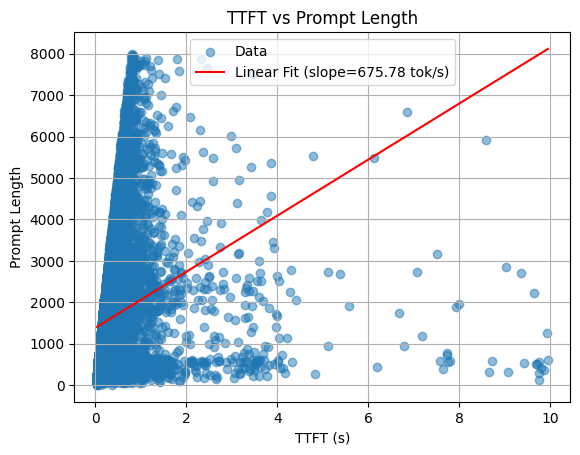

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

prompt_lengths = []
ttfts = []
for request in requests:
    prompt_lengths.append(request.prompt_tokens)
    ttfts.append(request.ttft)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(ttfts, prompt_lengths)

# Compute regression line
ttft_range = np.linspace(min(ttfts), max(ttfts), 100)
predicted_lengths = slope * ttft_range + intercept

# Plot
plt.scatter(ttfts, prompt_lengths, alpha=0.5, label="Data")
plt.plot(ttft_range, predicted_lengths, color='red', label=f"Linear Fit (slope={slope:.2f} tok/s)")
plt.ylabel("Prompt Length")
plt.xlabel("TTFT (s)")
plt.title("TTFT vs Prompt Length")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
model_name = f"meta-llama/Llama-3.1-8B::prefill"
tok_counter_metrics = router_metrics[model_name].get(tok_counter_metric, [])
tok_counter_timestamps = [float(t[0]) - router_start_time for t in tok_counter_metrics]
tok_counter_values = [float(t[1]) for t in tok_counter_metrics]
from time_series import TimeSeriesFunction
tok_counter_time_series = TimeSeriesFunction(tok_counter_timestamps, tok_counter_values)
print(f"length of tok_counter_time_series: {len(tok_counter_time_series.timestamps)}")

KeyError: 'meta-llama/Llama-3.1-8B::prefill'

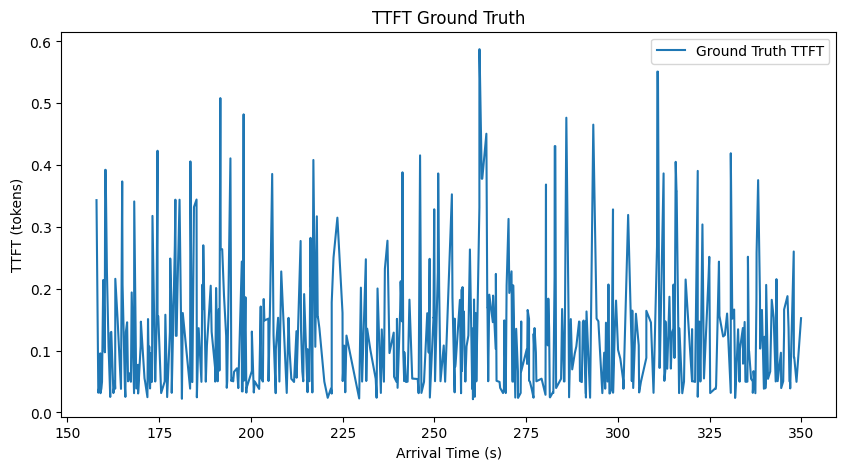

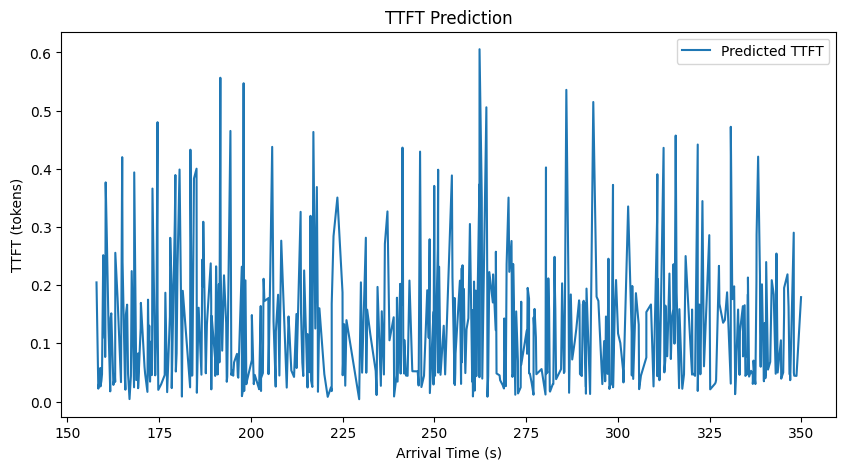

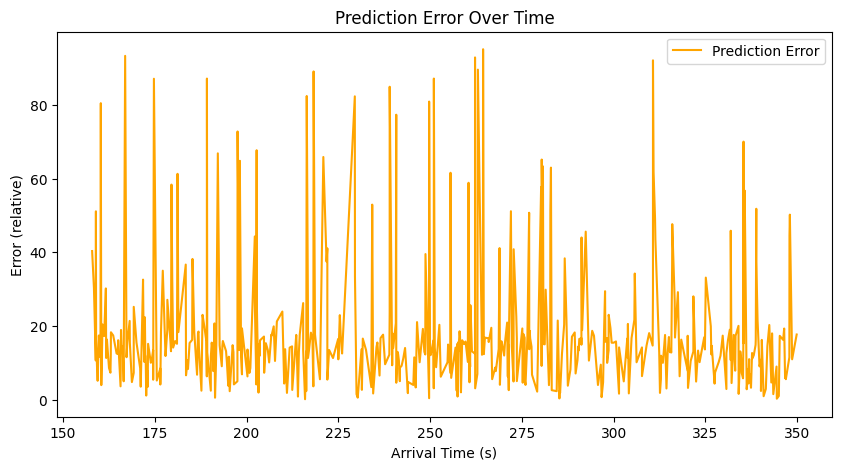

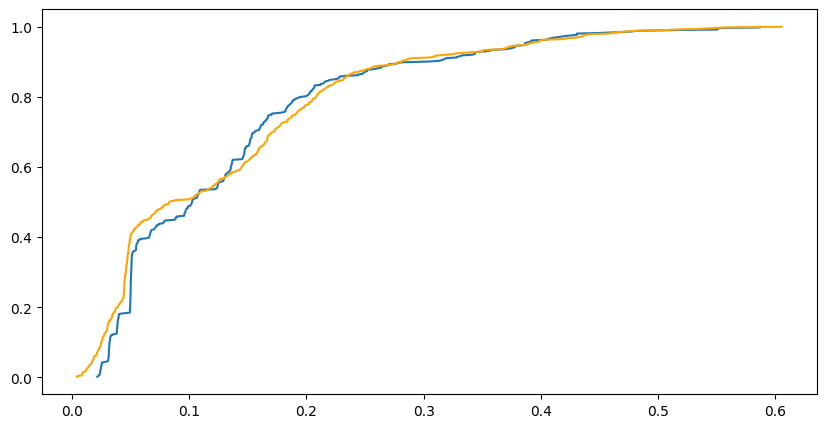

In [ ]:
arrival_timestamps = []
ground_truth_ttfts = []
predicted_ttfts = []
errors = []
tok_counters = []
TGT = 12500
for request in requests:
    time_offset = request.arrival_time - router_start_time
    tok_counter = tok_counter_time_series_gt.get_nearest_value(time_offset)
    tok_counters.append(tok_counter)
    groud_truth_ttft = request.ttft
    predicted_ttft = (request.prompt_tokens) / TGT
    error = (abs(predicted_ttft - groud_truth_ttft) / groud_truth_ttft) * 100
    errors.append(error)

    arrival_timestamps.append(time_offset)
    ground_truth_ttfts.append(groud_truth_ttft)
    predicted_ttfts.append(predicted_ttft)
combined = list(zip(arrival_timestamps, ground_truth_ttfts, predicted_ttfts, errors))

# Sort by arrival_timestamps (first element of each tuple)
combined.sort(key=lambda x: x[0])

# Unzip the sorted tuples back into individual lists
arrival_timestamps, ground_truth_ttfts, predicted_ttfts, errors = map(list, zip(*combined))
plt.figure(figsize=(10, 5))
plt.plot(arrival_timestamps, ground_truth_ttfts, label='Ground Truth TTFT')
plt.xlabel('Arrival Time (s)')
plt.ylabel('TTFT (tokens)')
plt.title('TTFT Ground Truth')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(arrival_timestamps, predicted_ttfts, label='Predicted TTFT')
plt.xlabel('Arrival Time (s)')
plt.ylabel('TTFT (tokens)')
plt.title('TTFT Prediction')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(arrival_timestamps, errors, label='Prediction Error', color='orange')
plt.xlabel('Arrival Time (s)')
plt.ylabel('Error (relative)')
plt.title('Prediction Error Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

data = np.sort(ground_truth_ttfts)
cdf = np.arange(1, len(data)+1) / len(data)

plt.plot(data, cdf, label='Ground Truth TTFT CDF')
data = np.sort(predicted_ttfts)
cdf = np.arange(1, len(data)+1) / len(data)

plt.plot(data, cdf,label='Predicted TTFT CDF', color='orange')
    

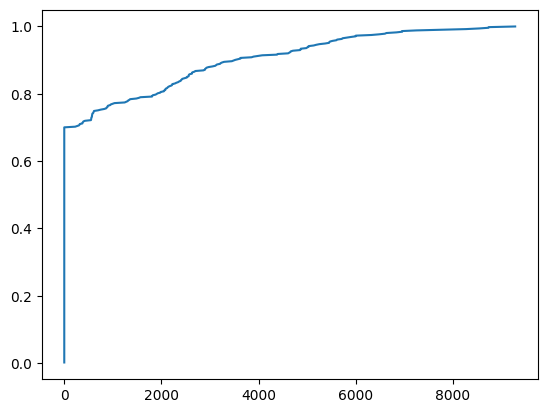

In [ ]:

data = np.sort(tok_counters)
cdf = np.arange(1, len(data)+1) / len(data)

plt.plot(data, cdf)

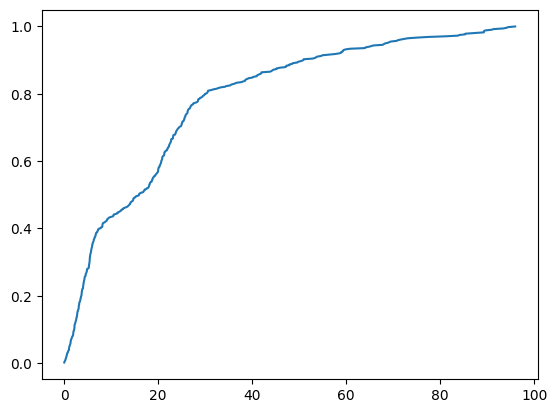

In [ ]:
data = np.sort(errors)
cdf = np.arange(1, len(data)+1) / len(data)

plt.plot(data, cdf)